In [2]:
#IMPORTING BASE PACAKAGES
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.signal import find_peaks
import os

In [3]:
#OPENING DRIVE
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/Lab_2_Group_4a/") #Setting Local Directory to Lab Folder

Mounted at /content/drive


In [4]:
#IMPORTING CUSTOM PACKAGES
import readData as rd

In [5]:
#@title Convert .raw files to .fits (Don't need to run unless you uploaded new data)
#CONVERTING .RAW FILES TO .FITS FOR DIRECTORIES
#Directory -> Folders -> Files
shape = (1240,1616) #shape of .raw files
dirs = ["DATA"]#["FULL_FRAMES", "DARK_FRAMES", "DATA"] #All Directories with Data
filter = ["Cloud_1004", "Cloud_Background_1004", "Neon_Line_Lamp_1004","Neon_Line_Background_1004"]#populate if you only want to convert specific directories, must constrain dirs to 1 element
for directory in dirs:
  sub_directories = os.listdir(directory) #Listing subfolders in directory
  if len(filter) > 0:
    for folder in filter:
      rd.raw_2_fits_folder(directory + "/" + folder+'/', shape=shape)#converting files in subfolders
  else:
    for folder in sub_directories:
      rd.raw_2_fits_folder(directory + "/" + folder+'/', shape=shape)#converting files in subfolders

In [6]:
# @title Detector Characterization

# DETECTOR CHARACTERIZATION
dirs = ["FULL_FRAMES", "DARK_FRAMES", "DATA"]    #All Directories with Data
readout_data = rd.read_Fits(dirs[0] + "/11us/")  #loading data for read out noise values
photon_data = rd.read_Fits(dirs[0] + "/998us/")  #loading data photon noise values
bias_data = rd.read_Fits(dirs[1] + "/10us/")     #loading data bias values
gain = []                                        #will hold gain values
dark_current = []                                #will hold dark current values
saturation = 255                                 #saturation value for detector

readout, readout_error = readout_data.mean(axis=0), readout_data.std(axis=0) / readout_data.shape[0]  #readout noise + standard error
photon, photon_error = photon_data.mean(axis=0), photon_data.std(axis=0) / photon_data.shape[0]       #photon noise + standard error
bias, bias_error = bias_data.mean(axis=0), bias_data.std(axis=0) / bias_data.shape[0]                 #bias + standard error

pe2 = np.power(photon_error,2)  #photon error squared (values are gonna get reused a few times)
gain = photon / pe2             #gain

# Calculating error in gain
a1 = 1/pe2                    # (dgain/dphoton * photon_error)^2
a2= 0                         # (dgain/dphoton_error * photon_error_error)^2 We currently do not have the data required to calculate the uncertainty of the photon_error
gain_error = np.sqrt(a1 + a2) # approximate value but slight underestimation as a2=0


print(f"Saturation on detector: {saturation}")

print(f"Gain: {np.mean(gain)} ADU")
print(f'Gain Error: {np.mean(gain_error)} ADU')

print(f"Photon: {np.mean(photon)} ADU")
print(f"Photon Error: {np.mean(photon_error)} ADU")

print(f"Bias: {np.mean(readout)} ADU")
print(f"Bias Error: {np.mean(readout_error)} ADU")

#Currently lacking data for dark current values

Saturation on detector: 255
Gain: 7.086112759908977 ADU
Gain Error: 0.18864608604544345 ADU
Photon: 197.64486935084636 ADU
Photon Error: 5.326534812428899 ADU
Bias: 1.9273346175343347 ADU
Bias Error: 0.060958460083850745 ADU


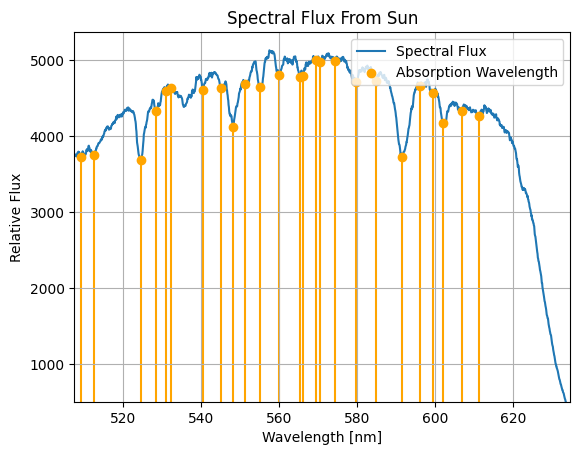

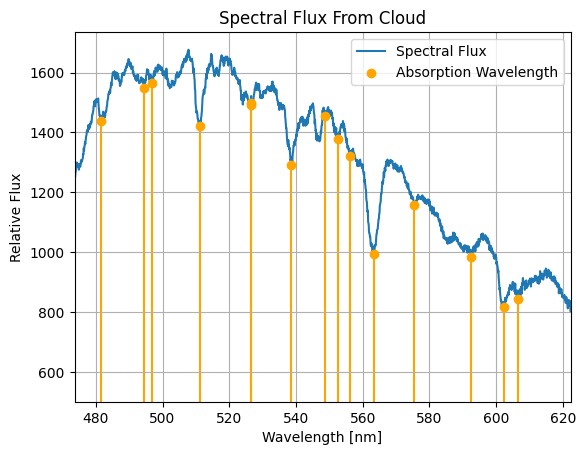

In [7]:
#@title Getting Cleaned Solar and Cloud Spectrums
def get_clean_spectrum(data_dir, bg_dir, full_frame_dir, saturation=255):
  #Final Frame = (Obj - Dark) / (Flat - Dark)
  mean_data = rd.read_Fits(data_dir).mean(axis=0)
  mean_bg = rd.read_Fits(bg_dir).mean(axis=0)
  flat = rd.read_Fits(full_frame_dir).mean(axis=0)

  flat *= saturation/flat.max() #setting flat to saturation value
  flat -= mean_bg #creating denominator for formula
  flat[flat<0] = 1 #dropping negative values
  flat /= flat.max() #setting max value to 1
  mean_data -= mean_bg #creating numerator
  mean_data[mean_data<0] = 0 #dropping negative values
  return mean_data/flat

cloud = get_clean_spectrum("DATA/Cloud_1004/", "DATA/Cloud_Background_1004/", "FULL_FRAMES/998us/")
cloud_neon = get_clean_spectrum("DATA/Neon_Line_Lamp_1004/","DATA/Neon_Line_Background_1004/", "FULL_FRAMES/998us/")
solar = get_clean_spectrum("DATA/Sun_0929/", "DATA/Sun_Background_0929/", "FULL_FRAMES/998us/")
solar_neon = get_clean_spectrum("DATA/Neon_Line_Lamp_0929/","DATA/Neon_Line_Background_0929/", "FULL_FRAMES/998us/")


#Setting up Pixel to wavelength converter
known_neon = np.genfromtxt("Known_Neon_Lines.csv",delimiter=',',dtype="str",skip_header=True)[:,1:] #known neon lines
wl = known_neon[:,1].astype(float)#getting wavelength values
wl = wl[(wl>=600)* (wl<= 700)]#picking out observed lines

cloud_neon_mv = (cloud_neon * gain).max(axis=0) #converting values to electrons and not ADU
solar_neon_mv = (solar_neon * gain).max(axis=0) #converting values to electrons and not ADU
cn_peaks, __ = find_peaks(cloud_neon_mv,height=150,prominence = 150,distance=10)#lazy so I hard coded values :p
sn_peaks, __ = find_peaks(solar_neon_mv,height=150,distance=10,prominence = 150,width=2)#dw about it lmao

row_x = np.arange(0,len(cloud_neon_mv),1)
c_coeff = np.polyfit(row_x[cn_peaks], wl[:len(cn_peaks)], 1)
cloud_conv = np.poly1d(c_coeff) #conversion for cloud
s_coeff = np.polyfit(row_x[sn_peaks], wl[:len(sn_peaks)], 1)
solar_conv = np.poly1d(s_coeff) #conversion for sun

#Getting Solar Absorbtion Spectrum
thresh = 0.15 #threshold of peak value that we are counting for spectral flux
s_flux = [] #spectral flux for each column
c_flux = []
for i in range(solar.shape[1]):
  #indexing areas with threshold value of peak, threshold is set to mean backgroud reading if too small
  peak_indices = solar[:,i] > solar[:,i].max()*thresh
  s_flux.append(solar[:,i][peak_indices].sum())#summing spectral flux

  peak_indices = cloud[:,i] > cloud[:,i].max()*thresh
  c_flux.append(cloud[:,i][peak_indices].sum())#summing spectral flux

s_flux = np.array(s_flux)
s_indices, __ = find_peaks(-s_flux,threshold=5,distance=3,width=5)
c_flux = np.array(c_flux)
c_indices, __ = find_peaks(-c_flux,threshold=3,distance=3,width=5)

#Plotting Solar Absorption
plt.plot(solar_conv(row_x),s_flux,zorder=2,label='Spectral Flux')
plt.scatter(solar_conv(row_x)[s_indices],s_flux[s_indices],color='orange',zorder=3,label='Absorption Wavelength')
for dex in s_indices:
  plt.vlines(solar_conv(row_x[dex]), 500, s_flux[dex],color='orange',zorder=1)
plt.ylim(500)
plt.xlim(solar_conv(row_x)[0],solar_conv(row_x)[-1])
plt.grid();
plt.ylabel("Relative Flux")
plt.xlabel("Wavelength [nm]")
plt.title("Spectral Flux From Sun")
plt.legend(loc='upper right');
# plt.savefig()
plt.show()

#Plotting Cloud Absorbtion
plt.plot(cloud_conv(row_x),c_flux,zorder=2,label='Spectral Flux')
plt.scatter(cloud_conv(row_x)[c_indices],c_flux[c_indices],color='orange',zorder=3,label='Absorption Wavelength')
for dex in c_indices:
  plt.vlines(cloud_conv(row_x[dex]), 500, c_flux[dex],color='orange',zorder=1)
plt.ylim(500)
plt.xlim(cloud_conv(row_x)[0],cloud_conv(row_x)[-1])
plt.grid();
plt.ylabel("Relative Flux")
plt.xlabel("Wavelength [nm]")
plt.title("Spectral Flux From Cloud")
plt.legend(loc='upper right');
# plt.savefig()
plt.show()


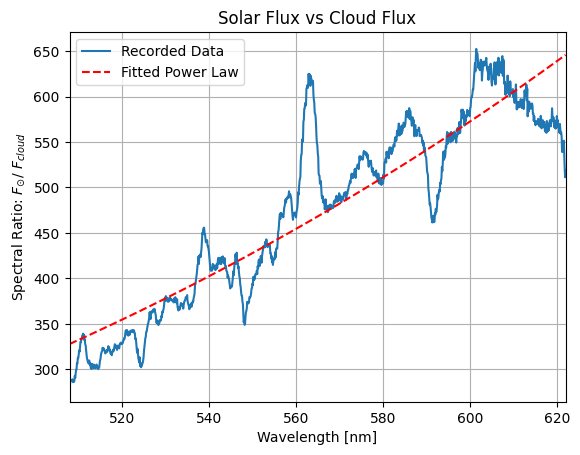

In [10]:
sx = solar_conv(row_x)
cx = cloud_conv(row_x)

mapping = np.arange(int(sx[0])+1,int(cx[-1]),0.1) #standardizing wavelengths
#finding closest values to map
def closest_indii(arr, map):
  out = []
  for elm in map:
    out.append(np.abs(elm-arr).argmin())
  return np.array(out)
s_ind = closest_indii(sx,mapping)
c_ind = closest_indii(cx,mapping)

#Putting flux into electrons/s
s_c = 1e6/19999
c_c = 1e6/2500003
s_f = np.copy((s_flux*s_c)[s_ind])
c_f = np.copy((c_flux*c_c)[c_ind])


def fit_func(x,a0,a1):
  return a0 * np.power(x,a1)

flux_ratio = s_f/c_f
par,cov = sp.optimize.curve_fit(fit_func, mapping, flux_ratio)

plt.plot(mapping,flux_ratio,label='Recorded Data')
plt.plot(mapping,fit_func(mapping,*par),color='red',linestyle='--',label='Fitted Power Law')
plt.xlabel("Wavelength [nm]")
plt.ylabel("Spectral Ratio: $F_{\odot}$/ $F_{cloud}$")
plt.xlim(mapping[0],mapping[-1])
plt.grid();
plt.title("Solar Flux vs Cloud Flux")
plt.legend(loc='upper left');


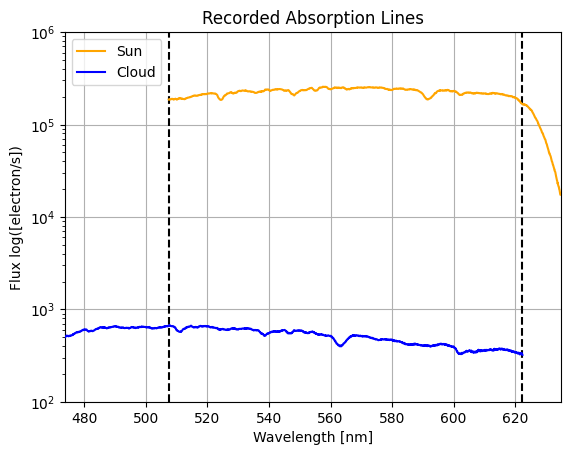

In [11]:
#Plotting Solar Absorbtion

s_big = [2,8,10,19,22]
plt.plot(solar_conv(row_x),s_flux*s_c,color='orange',zorder=3,label='Sun')



plt.plot(cloud_conv(row_x),c_flux*c_c,color='blue',zorder=3,label='Cloud')

plt.xlim(cloud_conv(row_x)[0],solar_conv(row_x)[-1])
plt.grid();
plt.ylabel("Flux log([electron/s])")
plt.xlabel("Wavelength [nm]")
plt.title("Recorded Absorption Lines")

# plt.savefig()
plt.yscale('log')
plt.ylim(1e2,1e6)

sx = solar_conv(row_x)
cx = cloud_conv(row_x)

plt.vlines([sx[0],cx[-1]],1e2,1e6,color='black',linestyle='--')
plt.legend(loc='upper left');
plt.show()

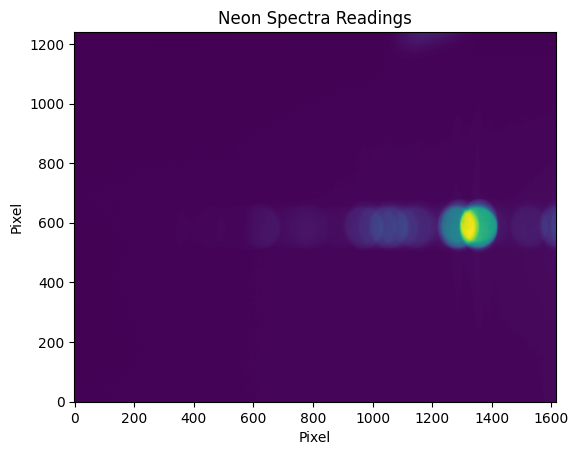

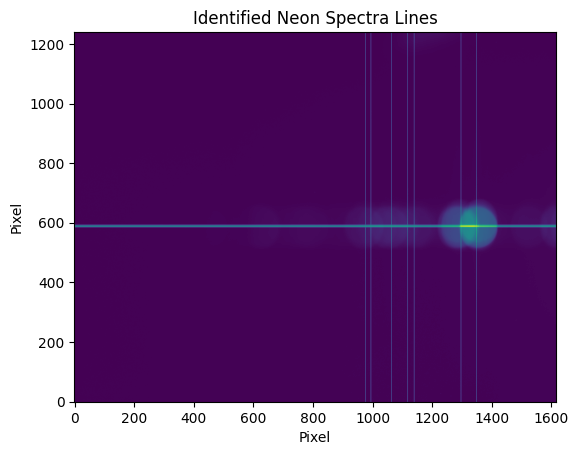

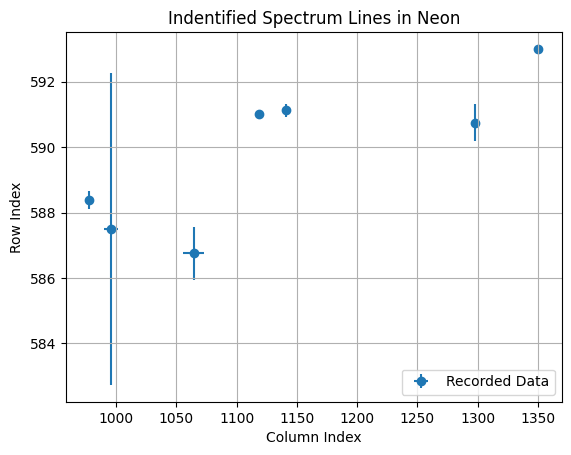

In [16]:
# @title Neon Spectra Analysis

neon_lines = np.genfromtxt("Neon_Lines.csv",dtype='float',delimiter=',').reshape((7,8,3)) #Loading Identified Neon Lines from savefile
neon_data = rd.read_Fits("DATA/Neon/").mean(axis=0)                                       #recorded neon data

mask = np.zeros(neon_data.shape)      #creating a mask layer to show where peaks are
for i in range(neon_lines.shape[0]):  #looping for each identified line
  row = int(neon_lines[i,:,0].mean()) #getting row index for peak
  col = int(neon_lines[i,:,1].mean()) #getting col index for peak
  # val = neon_lines[i,:,2].mean()    #Value of spectra line, not needed for this code tidbit
  mask[row,:] = neon_data.max()       #creating "-" centered on peak
  mask[:,col] = neon_data.max()       #creating "|" centered on peak

# Plotting Regular Data
plt.imshow(neon_data,origin='lower')
plt.title("Neon Spectra Readings")
plt.xlabel("Pixel")
plt.ylabel("Pixel")
plt.show()

# Plotting Data with mask overlayed, Each vertical line represent a peak,
plt.imshow(neon_data+mask,origin='lower')   #note that some peaks are less visible because of scaling, can use np.clip() to identify them
plt.title("Identified Neon Spectra Lines")
plt.xlabel("Pixel")
plt.ylabel("Pixel")
plt.show();

# Calculating Position of Spectra Lines on Detector Pixel and Plotting:
x_lines, y, size, xerr, yerr, = [], [], [], [], []
for i in range(neon_lines.shape[0]):                                  #looping for each identified line
  row = neon_lines[i,:,0].mean()                                      #getting row index for peak
  row_error = neon_lines[i,:,0].std() / np.sqrt(neon_lines.shape[2])  #getting standard error
  col = neon_lines[i,:,1].mean()                                      #getting col index for peak
  col_error = neon_lines[i,:,1].std() / np.sqrt(neon_lines.shape[2])  #getting standard error
  val = neon_lines[i,:,2].mean()                                      #Value of spectra line, not needed for this code tidbit
  val_error = neon_lines[i,:,2].std() / np.sqrt(neon_lines.shape[2])  #getting standard error

  # Saving Values to Arrays
  x_lines.append(col)
  xerr.append(col_error)
  y.append(row)
  yerr.append(row_error)
  size.append(val)

# Plotting Data
plt.errorbar(x_lines,y, xerr = xerr,yerr = yerr,fmt='o',zorder=1,label='Recorded Data')
# plt.scatter(x_lines,y,s=size,color='red',zorder=2,label='Intensity')
plt.legend(loc='lower right')
plt.title("Indentified Spectrum Lines in Neon")
plt.ylabel("Row Index")
plt.xlabel("Column Index")
plt.grid();

Peak row for range 1000_1200 is at x-index: 1101
Peak row for range 1200_1400 is at x-index: 1279
Peak row for range 1400_1616 is at x-index: 1350


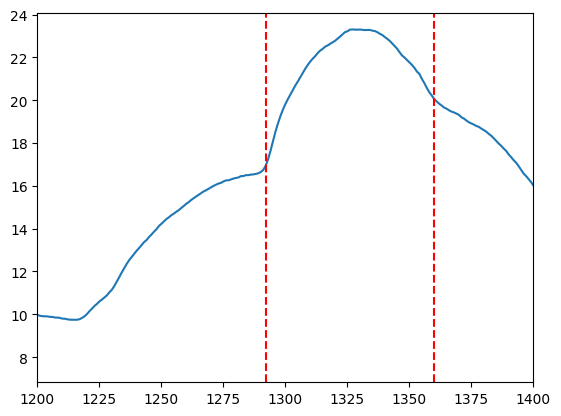

In [17]:
x_ranges = {
    "1000_1200": (1000, 1200),
    "1200_1400": (1200, 1280),
    "1400_1616": (1350, 1450)
}

# Calculate peak rows within specified x-axis ranges
peak_rows = {}
for key, (start, end) in x_ranges.items():
    peak_index = neon_data[:, start:end].mean(axis=0).argmax()
    peak_rows[key] = peak_index + start  # Adjust index to global column index

# Output peaks
for key, peak_row in peak_rows.items():
    print(f"Peak row for range {key} is at x-index: {peak_row}")

x = np.arange(0, neon_data.shape[1])

plt.plot(x, neon_data.mean(axis=0))
plt.xlim(1200, 1400)
plt.axvline(x=1292, color='r', linestyle='--')
plt.axvline(x=1360, color='r', linestyle='--')
plt.show()

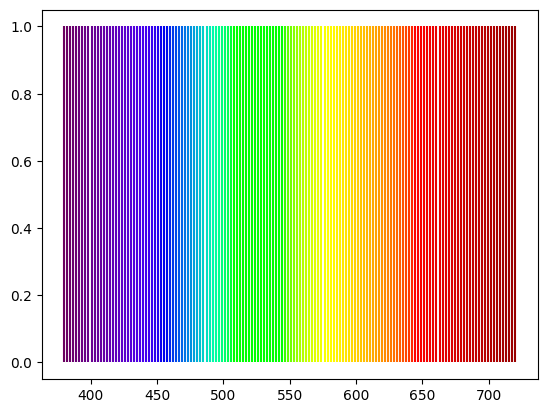

In [18]:
#@title Sample Code for Creating Spectra Line Graph
#spectra line graph
w2r = np.genfromtxt('w2r_blend.csv', delimiter=' ') #wavelength to rgb array

def wl_2_rgb(lam): #converts wavelength in nm to rgb value
  global w2r
  return w2r[np.abs(w2r[:,0] - lam).argmin()]

l = np.linspace(380,720,150) #creating wavelengths from 380nm to 720nm
for x in l:
    plt.vlines(x,0,1,color=wl_2_rgb(x)[1:]) #plotting wavelengths with associated rgb color

In [19]:
(neon_data+mask).shape

(1240, 1616)

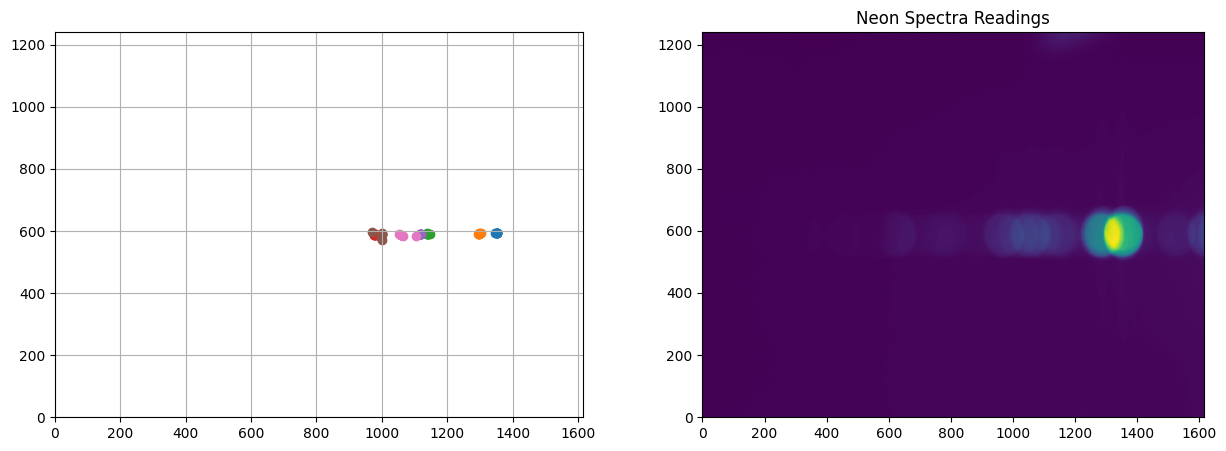

In [20]:
x = np.linspace(0, 1616, 100)
y = np.linspace(0, 1240, 100)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))


ax1.set_xlim(x[0], x[-1])
ax1.set_ylim(y[0], y[-1])

ax1.set_xticks(np.arange(x[0], x[-1] + 1, 200))
ax1.set_yticks(np.arange(y[0], y[-1] + 1, 200))

for sub_array in neon_lines:
    y_values = sub_array[:, 0]
    x_values = sub_array[:, 1]

    # Plot each point in the sub-array, color coded for each 2D matrix within neon_lines
    ax1.scatter(x_values, y_values, label='Data Points')

ax1.grid(True)


mask = np.zeros(neon_data.shape) #creating a mask layer to show where peaks are
for i in range(neon_lines.shape[0]): #looping for each identified line
  row = int(neon_lines[i,:,0].mean()) #getting row index for peak
  col = int(neon_lines[i,:,1].mean()) #getting col index for peak
  # val = neon_lines[i,:,2].mean() #Value of spectra line, not needed for this code tidbit
  mask[row,:] = neon_data.max() #creating "-" centered on peak
  mask[:,col] = neon_data.max() #creating "|" centered on peak

#Plotting Regular Data
ax2.imshow(neon_data,origin='lower')
ax2.set_title("Neon Spectra Readings")

plt.show()

In [21]:
# Sort each 2D sub-array by the second column
for i in range(len(neon_lines)):
    neon_lines[i] = neon_lines[i][neon_lines[i][:, 1].argsort()]

# Sort the entire 3D array by the first value of the first column of each sub-array
indices = np.argsort(neon_lines[:, 0, 0])
neon_lines = neon_lines[indices]

print("Sorted neon_lines:\n", neon_lines)

Sorted neon_lines:
 [[[ 588.     975.       9.2  ]
  [ 589.     976.       8.4  ]
  [ 588.     977.       9.8  ]
  [ 589.     978.       9.2  ]
  [ 588.     978.       9.2  ]
  [ 588.     979.       9.6  ]
  [ 589.     980.      10.4  ]
  [ 588.     980.       9.4  ]]

 [[ 589.    1051.      33.2  ]
  [ 588.    1058.      42.6  ]
  [ 586.    1059.      43.2  ]
  [ 587.    1059.      43.   ]
  [ 588.    1059.      42.6  ]
  [ 586.    1060.      42.8  ]
  [ 585.    1064.      44.   ]
  [ 585.    1104.      33.525]]

 [[ 590.    1294.      46.4  ]
  [ 590.    1296.      50.4  ]
  [ 592.    1297.      52.2  ]
  [ 590.    1297.      49.2  ]
  [ 590.    1297.      47.8  ]
  [ 590.    1297.      50.   ]
  [ 592.    1300.      54.6  ]
  [ 592.    1302.      53.8  ]]

 [[ 591.    1116.      23.725]
  [ 591.    1118.      23.925]
  [ 591.    1118.      24.325]
  [ 591.    1118.      24.325]
  [ 591.    1119.      23.925]
  [ 591.    1119.      23.725]
  [ 591.    1119.      23.725]
  [ 591.    1

In [22]:
import pandas as pd
from io import StringIO

data = """90 352.9549 Ne II P71
60 354.9620 Ne II P71
90 361.4321 Ne II P71
60 362.4544 Ne II P71
150 405.8538 Ne II P71
120 407.1377 Ne II P71
200 445.0393 Ne II P71
300 446.2552 Ne II P71
250 446.5902 Ne II P71
200 447.8146 Ne II P71
150 454.6540 Ne II P71
200 455.2730 Ne II P71
10 456.2728 Ne II P71
120 456.3485 Ne II P71
90 456.8962 Ne II P71
1000 460.7284 Ne II P71
500 462.3908 Ne II P71
30 587.2127 Ne I SS04
30 587.1792 Ne I SS04
30 589.9114 Ne I SS04
70 591.8306 Ne I SS04
100 595.9200 Ne I SS04
70 598.7056 Ne I SS04
30 598.8897 Ne I SS04
70 600.0365 Ne I SS04
130 602.7263 Ne I SS04
170 615.6283 Ne I SS04
170 618.6716 Ne I SS04
130 619.1023 Ne I SS04
200 626.8232 Ne I SS04
200 629.7388 Ne I SS04
1000 735.8962 Ne I SS04
400 743.7195 Ne I SS04"""

# Read the data into a DataFrame
df = pd.read_csv(StringIO(data), sep=' ', header=None)



# Display the DataFrame
print(df[1].values)
print(df[0].values)

[352.9549 354.962  361.4321 362.4544 405.8538 407.1377 445.0393 446.2552
 446.5902 447.8146 454.654  455.273  456.2728 456.3485 456.8962 460.7284
 462.3908 587.2127 587.1792 589.9114 591.8306 595.92   598.7056 598.8897
 600.0365 602.7263 615.6283 618.6716 619.1023 626.8232 629.7388 735.8962
 743.7195]
[  90   60   90   60  150  120  200  300  250  200  150  200   10  120
   90 1000  500   30   30   30   70  100   70   30   70  130  170  170
  130  200  200 1000  400]


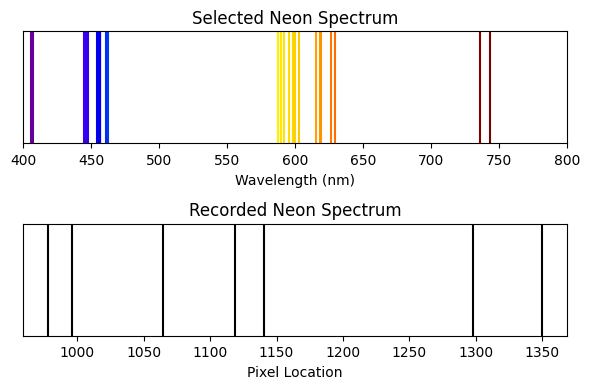

In [23]:
# wavelengths = df[1].astype(float)[(df[1].astype(float) >= 600) & (df[1].astype(float) <= 700)]
wavelengths = df[1].astype(float)[(df[1].astype(float) >= 400) & (df[1].astype(float) <= 800)]
# wavelengths = df[1].astype(float)

# Merging two plots
plt.figure(figsize=(6, 4))

# Subplot 1: Selected Neon Spectrum
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot
for line in wavelengths:
    plt.vlines(line, 0, 1, color=wl_2_rgb(line)[1:])  # Change color as needed

plt.ylim(0, 1)
plt.title("Selected Neon Spectrum")
plt.xlabel("Wavelength (nm)")
# plt.xlim(592, 632)
plt.xlim(400, 800)
plt.yticks([])

# Subplot 2: Recorded Neon Spectrum
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot
for line in x_lines:
    plt.vlines(line, 0, 1, color='black')  # Change color as needed

plt.ylim(0, 1)
plt.title("Recorded Neon Spectrum")
plt.xlabel("Pixel Location")
plt.yticks([])

plt.tight_layout()  # Adjust spacing
plt.show()

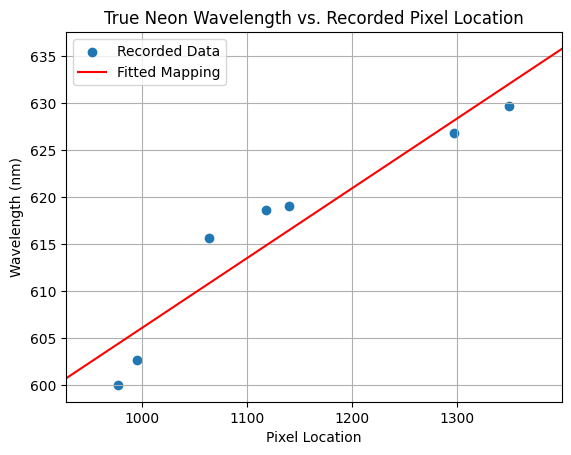

In [26]:
wavelengths2 = df[1].astype(float)[(df[1].astype(float) >= 600) & (df[1].astype(float) <= 700)]
x_lines = np.array(x_lines)
x_lines = x_lines[x_lines.argsort()]

coefficients = np.polyfit(x_lines, wavelengths2, 1)
polynomial = np.poly1d(coefficients)

min_x = x_lines.min() - 50
max_x = x_lines.max() + 50

# Sample the polynomial within the omega_m_range
x_fine = np.linspace(min_x, max_x, 30)
y_fine = polynomial(x_fine)

# Maximum likelihood value
max_xx = x_fine[np.argmax(y_fine)]


# plt.plot(x_lines, wavelengths)
plt.scatter(x_lines, wavelengths2, label='Recorded Data')
plt.plot(x_fine, y_fine, color='red', label='Fitted Mapping')
plt.xlabel("Pixel Location")
plt.ylabel("Wavelength (nm)")
plt.xlim(min_x, max_x)
plt.title("True Neon Wavelength vs. Recorded Pixel Location")
plt.legend()
plt.grid();
plt.show()

In [30]:
#@title Creating readData.py
%%writefile readData.py

from astropy.io import fits
import struct
import numpy as np
import os

def raw_to_fits(raw_file, shape=(1080,1440), destination=None, ADC_bits = 12, simu_artifacts = False):
    """
    Converts a .raw file to a FITS formatted image
    raw_file : The file path of the raw image
    shape : A list or tuple with (# of rows, # of columns) for the image
    destination : an alternate destination/filename for the FITS image
      (default is to replace the .raw extension and save in the same folder)
    """
    tint = float(raw_file.split(".raw")[0].split("_")[-1].split('us')[0])/1e6

    # Get shape of image
    nrows, ncols = shape
    # Open raw file
    with open(raw_file, 'rb') as raw:
        raw_img = raw.read()
    # Check file size / format
    filesize = len(raw_img)
    if filesize == nrows*ncols: # 8-bit
        size = 'B'
        file_bits = 8
    elif filesize == nrows*ncols*2: # 16-bit
        size = 'H'
        file_bits = 16
    else: # No size match
        raise ValueError("The image shape provided does not match the length of the file")
    # Format binary string
    fmt = f"<{nrows*ncols}{size}"
    # Convert byte string to numpy array
    byte_array = np.array(struct.unpack(fmt, raw_img)).reshape(nrows, ncols)
    if file_bits > ADC_bits:
        byte_array = byte_array/2**(file_bits-ADC_bits)

    if simu_artifacts:
        ny,nx = byte_array.shape

        # Adding dark
        dark_current = 1.25 #ADU/s
        byte_array += dark_current*tint

        # multiplying flat
        x_grid,y_grid = np.meshgrid(np.arange(nx),np.arange(ny))
        flat_field = np.exp(-0.5*((x_grid - nx//2)**2/(3*nx)**2+(y_grid - ny//2)**2/(3*ny)**2))
        byte_array *= flat_field

        state = np.random.get_state()
        np.random.seed(0)

        # adding hot pixels
        hot_pix_indices = np.random.randint(0, high=nx*ny-1, size=int(0.01*nx*ny))
        hot_pix_indices = np.unravel_index(hot_pix_indices, (ny,nx))
        byte_array[hot_pix_indices] *= tint*np.clip(30*np.random.randn(int(0.01*nx*ny)),dark_current,2**ADC_bits)

        # adding cold pixels
        cold_pix_indices = np.random.randint(0, high=nx*ny-1, size=int(0.01*nx*ny))
        cold_pix_indices = np.unravel_index(cold_pix_indices, (ny,nx))
        byte_array[cold_pix_indices] *= np.random.uniform(0,0.5,size=int(0.01*nx*ny))

        np.random.set_state(state)

        # Adding bias
        byte_array += 64

        # adding readnoise
        readnoise = 3 #ADU
        byte_array += readnoise*np.random.randn(ny,nx)

        byte_array = np.clip(byte_array,0,2**ADC_bits)

    # FITS file name
    if destination is None:
        fits_file = raw_file.replace('.raw', '.fits')
    else:
        fits_file = destination
    if simu_artifacts:
        fits_file = fits_file.replace(".fits", "_simu.fits")
    # Save as FITS
    hdu = fits.PrimaryHDU(byte_array)
    hdu.writeto(fits_file,overwrite=True)


def raw_2_fits_folder(dir,shape):
  """
  Creates .fits files from all .raw files in given directory
  Uses function raw_to_fits()
  """
  filenames = np.array(os.listdir(dir)) #Loading directory files
  raw_files = filenames[np.arange(0,len(filenames),1)[np.char.find(filenames,".raw") >= 0]] #getting all .raw files
  for fn in raw_files:
    raw_to_fits(dir + fn, shape=shape) #converting to .fits


def read_Fits(dir):
  """
  Loads all FITS files in given directory into a numpy array and returns it
  """
  filenames = np.array(os.listdir(dir)) #Loading directory files
  fits_files = filenames[np.arange(0,len(filenames),1)[np.char.find(filenames,".fits") >= 0]] #getting .fits files

  data = [] #output array
  for fn in fits_files:
    data.append(fits.open(dir+fn)[0].data) #loading fits data

  return np.array(data) #returning output array

Overwriting readData.py


In [31]:
blue_wave = polynomial(0)    #Use pixel val between ~950-1375
polynomial(1616)-polynomial(0),polynomial(1616),polynomial(0)

(120.12938426660389, 651.8681546909348, 531.7387704243309)

Text(0.5, 1.0, 'Oxygen Spectrum')

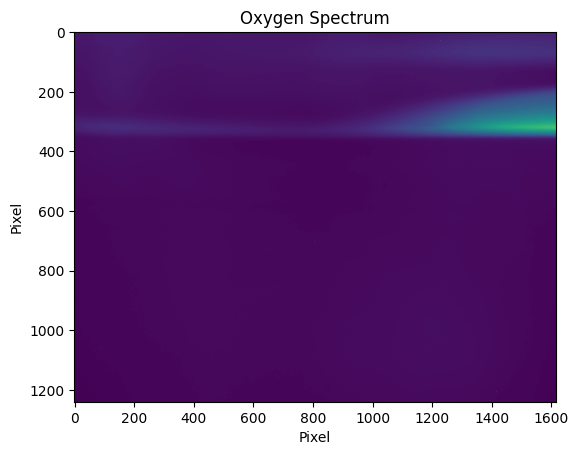

In [32]:
oxy =  rd.read_Fits("DATA/Oxygen/")
plt.imshow(oxy.mean(axis=0))
plt.xlabel("Pixel")
plt.ylabel("Pixel")
plt.title("Oxygen Spectrum")

Text(0.5, 1.0, 'Nitrogen Spectrum')

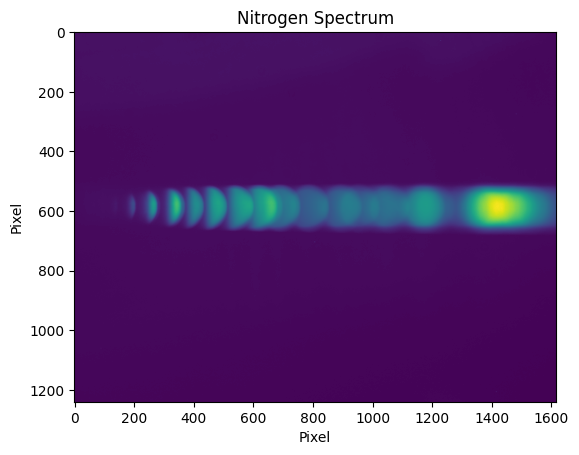

In [33]:
Nit = rd.read_Fits("DATA/Nitrogen/")
plt.imshow(Nit.mean(axis=0))
plt.xlabel("Pixel")
plt.ylabel("Pixel")
plt.title("Nitrogen Spectrum")